In [1]:
import numpy as np
import anndata as ad
import scanpy as sc
from scipy.sparse import csr_matrix, issparse
from tqdm import tqdm
from multiprocessing import Pool

from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm

In [2]:
adata = sc.read("/mnt/storage/adata_normalized_custom.h5ad")
adata.X = adata.layers["binarized"]

In [3]:
if issparse(adata.X):
    if not adata.X.has_sorted_indices:
        adata.X.sort_indices()

In [4]:
def process_column(i):
    return np.asarray(np.squeeze(adata.X[:,i].toarray()))

with Pool() as p:
    y = list(tqdm(p.imap(process_column, range(adata.X.shape[1])), total=adata.X.shape[1]))
y = np.array(y)

100%|██████████| 92653/92653 [05:02<00:00, 306.41it/s]


In [5]:
X = np.asarray(np.sum(adata.X, axis = 1)).astype(float)
X_res = np.zeros(adata.X.shape)

In [6]:
X.shape

(3683, 1)

### Assess model parameter stability: Bootstrapping

Sample from all cells with replacement 15 times

For each Gene:

Uncertainty Estimate = standard deviation of parameter estimates across 15 bootstraps divided by the standard deviation of the bootstrap-mean value.

Values greater or equal to one indicate high uncertainty, while values less or equal to 0.01 indicate low uncertainty.

In [11]:
def process_column_2(i):
    model = LogisticRegression(solver='liblinear', warm_start = True).fit(X = X,y = y[i])

    # Bootstrapping for uncertainty estimates:
    n_samples = 15
    bootstrapped_beta0 = np.zeros(n_samples)
    bootstrapped_beta1 = np.zeros(n_samples)
    beta_0 = model.intercept_
    beta_1 = model.coef_

    for j in range(n_samples):
        idx = np.random.randint(0, X.shape[0], X.shape[0])
        X_bootstrapped = X[idx, :]
        y_bootstrapped = y[i,idx]
        clf_bootstrapped = LogisticRegression(solver='liblinear', warm_start = True)
        clf_bootstrapped.fit(X_bootstrapped, y_bootstrapped)
        bootstrapped_beta0[j] = clf_bootstrapped.intercept_
        bootstrapped_beta1[j] = clf_bootstrapped.coef_

    # Compute the standard deviation of the coefficients
    std_beta_0 = np.std(bootstrapped_beta0)
    std_beta_1 = np.std(bootstrapped_beta1)
 
    # Compute standard deviation of the bootstrap-mean value across all genes
    std_mean_beta_0 = std_beta_0 / np.sqrt(n_samples)
    std_mean_beta_1 = std_beta_1 / np.sqrt(n_samples)

    #X_1 = np.hstack((np.ones((X.shape[0], 1)), X))
    #logit = sm.Logit(y, X_1)
    #result = logit.fit()
    #p_values = result.pvalues

    return y[i] - model.predict_proba(X)[:,1], beta_0, beta_1, std_beta_0, std_beta_1, bootstrapped_beta0, bootstrapped_beta1

with Pool() as p:
      X_res_and_coefs = list(tqdm(p.imap(process_column_2, range(adata.X.shape[1])), total=adata.X.shape[1]))

100%|██████████| 92653/92653 [09:42<00:00, 159.14it/s]


In [12]:
X_res_inv = list(zip(*X_res_and_coefs))

In [13]:
# Residual Matrix
X_res = np.array(X_res_inv[0]).T
X_res.shape

(3683, 92653)

In [14]:
n_samples = 15

bootstrapped_beta0 = np.array(X_res_inv[5]).flatten()
bootstrapped_beta1 = np.array(X_res_inv[6]).flatten()

std_beta_0 = np.array(X_res_inv[3]).flatten()
std_beta_1 = np.array(X_res_inv[4]).flatten()

uncertainty_beta_0 = std_beta_0 / (np.std(bootstrapped_beta0)/np.sqrt(n_samples))
uncertainty_beta_1 = std_beta_1 / (np.std(bootstrapped_beta1)/np.sqrt(n_samples))



In [15]:
adata.var["beta0_binaryresidual"] = np.array(X_res_inv[1]).flatten()
adata.var["beta1_binaryresidual"] = np.array(X_res_inv[2]).flatten()
adata.var["uncertainty_beta_0"] = uncertainty_beta_0 = std_beta_0 / (np.std(bootstrapped_beta0)/np.sqrt(n_samples))
adata.var["uncertainty_beta_1"] = uncertainty_beta_1 = std_beta_1 / (np.std(bootstrapped_beta1)/np.sqrt(n_samples))

adata.var

,chr,start,stop,n_cells,log_n_cells,passes_filter,prop_shared_cells,variability_score,highly_variable,beta0_binaryresidual,beta1_binaryresidual,uncertainty_beta_0,uncertainty_beta_1
chr1_3094514_3095439,chr1,3094514,3095439,260,2.414973,True,0.070595,0.570595,True,-2.990036,0.000076,0.249784,0.345324
chr1_3119448_3120695,chr1,3119448,3120695,591,2.771587,True,0.160467,0.660467,True,-2.598148,0.000138,0.211546,0.220595
chr1_3121324_3121602,chr1,3121324,3121602,201,2.303196,True,0.054575,0.554575,True,-3.244175,0.000081,1.539273,1.475091
chr1_3204778_3205112,chr1,3204778,3205112,83,1.919078,True,0.022536,0.522536,True,-4.741775,0.000133,0.509468,0.471255
chr1_3217091_3217445,chr1,3217091,3217445,58,1.763428,True,0.015748,0.515748,True,-4.577246,0.000072,0.398043,0.553464
...,...,...,...,...,...,...,...,...,...,...,...,...,...
chrY_90761057_90761966,chrY,90761057,90761966,515,2.711807,True,0.139832,0.639832,True,-2.865645,0.000135,0.958298,0.981933
chrY_90800353_90800641,chrY,90800353,90800641,92,1.963788,True,0.024980,0.524980,True,-4.540609,0.000121,1.822716,2.035784
chrY_90804546_90805253,chrY,90804546,90805253,446,2.649335,True,0.121097,0.621097,True,-3.250021,0.000158,0.596109,0.764720
chrY_90808426_90808933,chrY,90808426,90808933,407,2.609594,True,0.110508,0.610508,True,-2.778043,0.000106,1.145390,1.413678


In [30]:
adata.layers["binarized"] = X_res
adata.write("/mnt/storage/adata_custom_v2.h5ad")

In [34]:
import logging
import anndata2ri

import rpy2.rinterface_lib.callbacks as rcb
import rpy2.robjects as ro

sc.settings.verbosity = 0
sc.settings.set_figure_params(
    dpi=80,
    facecolor="white",
    # color_map="YlGnBu",
    frameon=False,
)
rcb.logger.setLevel(logging.ERROR)
ro.pandas2ri.activate()
anndata2ri.activate()

%load_ext rpy2.ipython

In [37]:
adata.X = adata.layers["binarized"]
ro.globalenv["adata"] = adata

: 

: 

In [2]:
adata = sc.read("/mnt/storage/adata_custom_v2.h5ad")
X = adata.layers["binarized"]

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

In [4]:
ReadCounts = np.asarray(np.sum(adata.X, axis = 0)).astype(float).flatten()
ReadCounts.shape

(92653,)

In [16]:
data_for_uncertainty_plot = {
    'beta_0': adata.var["beta0_binaryresidual"],
    'beta_1': adata.var["beta1_binaryresidual"],
    'library size': ReadCounts,
    'Uncertainty beta_0': adata.var["uncertainty_beta_0"],
    'Uncertainty beta_1': adata.var["uncertainty_beta_1"],
}

In [7]:
X.flatten().shape

(341240999,)

Text(0.5, 1.0, 'Binary Residual Transform: Distribution of Residuals')

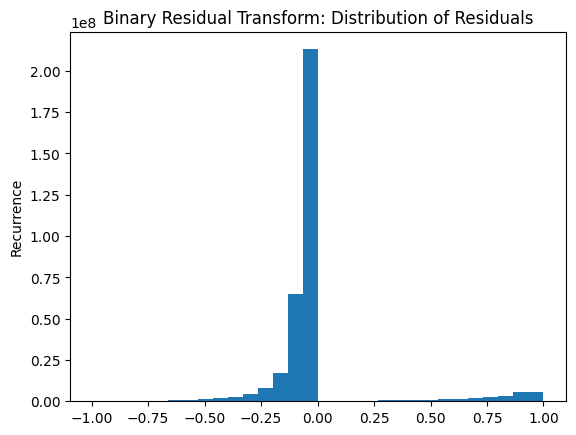

In [12]:
plt.hist(X.flatten(), bins = 30)
plt.ylabel('Recurrence')
plt.title('Binary Residual Transform: Distribution of Residuals')

Text(0.5, 1.0, 'SCTransform: Distribution of Residuals')

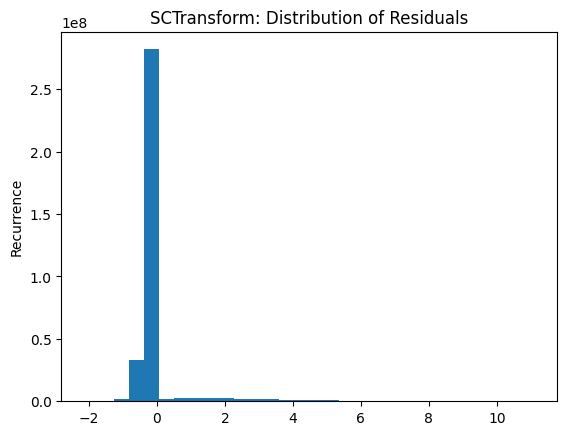

In [13]:
X_res = adata.layers["scTransform_normalization"]
plt.hist(X_res.flatten(), bins = 30)
plt.ylabel('Recurrence')
plt.title('SCTransform: Distribution of Residuals')

Text(0.5, 1.0, 'SCTransform with fixed θ: Distribution of Residuals')

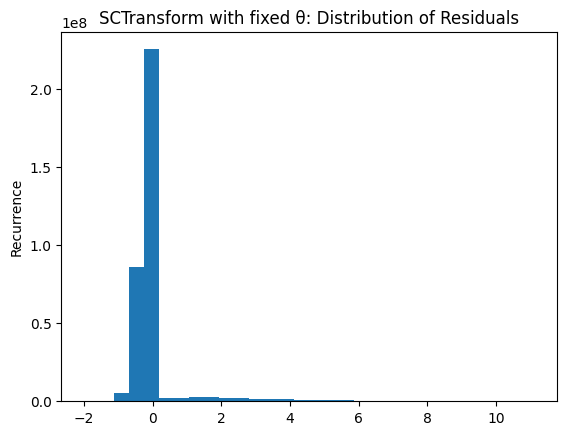

In [14]:
X_res = adata.layers["scTransform_normalization_c1"]
plt.hist(X_res.flatten(), bins = 30)
plt.ylabel('Recurrence')
plt.title('SCTransform with fixed θ: Distribution of Residuals')

/home/ubuntu/miniconda3/envs/residTransform/lib/python3.10/site-packages/seaborn/relational.py:573: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  points = ax.scatter(x=x, y=y, **kws)
/home/ubuntu/miniconda3/envs/residTransform/lib/python3.10/site-packages/seaborn/relational.py:573: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  points = ax.scatter(x=x, y=y, **kws)


[Text(0.5, 1.0, 'slopes vs library size')]

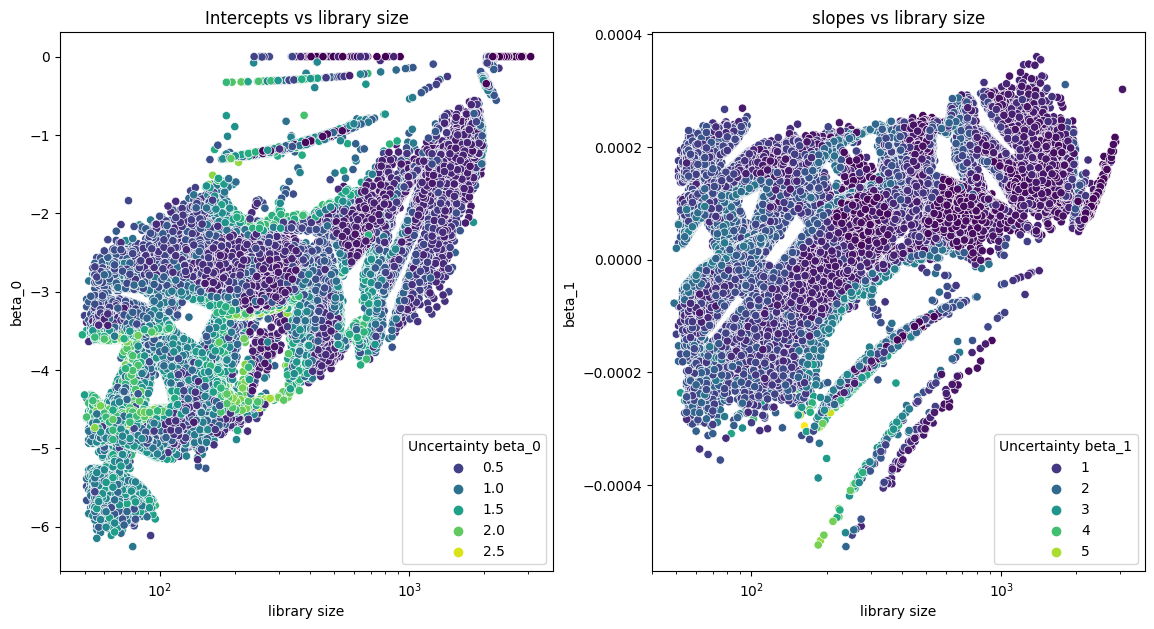

In [17]:
f, ax = plt.subplots(1, 2, figsize=(14, 7))

ax[0].set(xscale="log")
ax[1].set(xscale="log")

sns.scatterplot(data_for_uncertainty_plot, hue = "Uncertainty beta_0", y = 'beta_0', x = 'library size', palette='viridis', cmap='viridis', ax=ax[0]).set(title='Intercepts vs library size')
sns.scatterplot(data_for_uncertainty_plot, hue = "Uncertainty beta_1", y = 'beta_1', x = 'library size', palette='viridis', cmap='viridis', ax=ax[1]).set(title='slopes vs library size')

In [24]:
X_s = adata.layers["binarized"]
sum(sum(X_s))/(X_s.shape[0]*X_s.shape[1])

<1x92653 sparse matrix of type '<class 'numpy.float64'>'
	with 92653 stored elements in Compressed Sparse Row format>

In [25]:
sum(sum(X_s.toarray()))/(X_s.shape[0]*X_s.shape[1])

0.07516736287599486

Plots: Uncertainty (colour) beta0 (yaxis) gene mean (xaxis)
Plots: Uncertainty (colour) beta1 (yaxis) gene mean (xaxis)

Plots: Residual (y) vs sequencing depth (x)

Plots: Residual Mean (x) vs read count (y)
Plots: Residual variance (x) vs read count (y)

Text(0.5, 1.0, 'Distribution of Residuals')

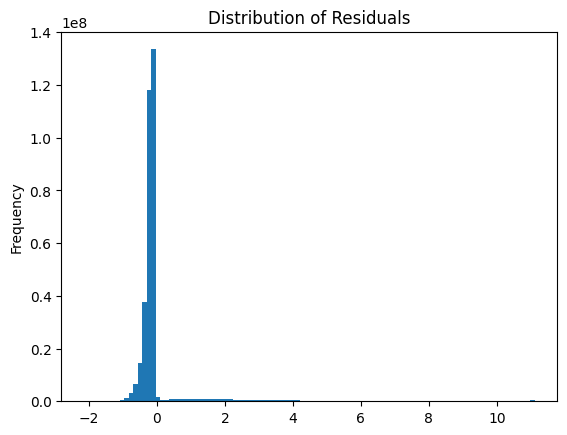

In [ ]:
X_res = adata.layers["scTransform_normalization"]
plt.hist(X_res.flatten(), bins = 100)
plt.ylabel('Frequency')
plt.title('Distribution of Residuals')

Text(0.5, 1.0, 'Distribution of Residuals')

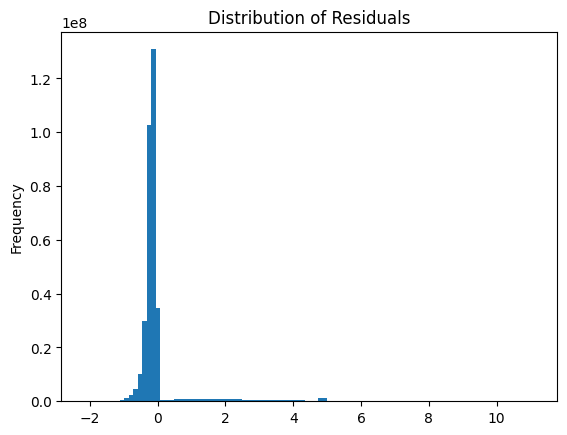

In [ ]:
X_res = adata.layers["scTransform_normalization_v2"]
plt.hist(X_res.flatten(), bins = 100)
plt.ylabel('Frequency')
plt.title('Distribution of Residuals')

Text(0.5, 1.0, 'Distribution of Residuals')

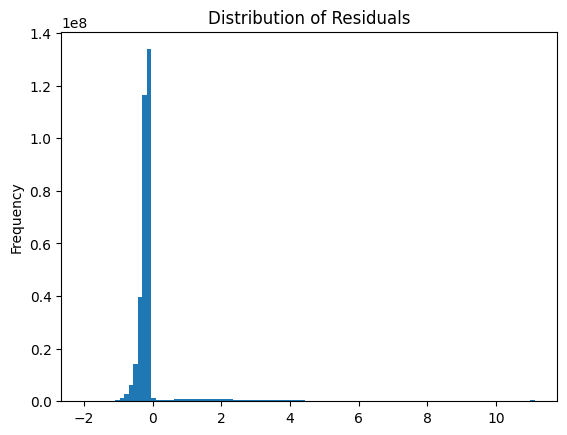

In [ ]:
X_res = adata.layers["scTransform_normalization_c1"]
plt.hist(X_res.flatten(), bins = 100)
plt.ylabel('Frequency')
plt.title('Distribution of Residuals')